In [1]:
# Data processing
import numpy as np
import pandas as pd
import datetime as dt

# Download data
import yfinance as yf

from scipy.stats import norm
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [2]:
# Initial investment and currency per stock

# in dollar values initially?

principle = 100000000 #100mil

# initial weights

# for respective instruments, and 10% for cash
weights = np.array([0.1,0.2,0.2,0.2,0.2, 0.1])

investment = {
    "DBA" : [10000000, 'USD'], # iPath Pure Beta Broad Commodity ETN (BCM)
    "EWQ" : [20000000, 'USD'], # iShares MSCI France ETF, NYSE, USD
    "^AEX"  : [20000000, 'EUR'], # AEX Index
    "^GSPC" : [20000000, 'USD'], # S&P 500 Index
    "^N225" : [20000000, 'JPY'] # Nikkei 225
}

start = "2010-01-01"
end = "2018-12-31"

In [3]:
# Download data and store in dataframe

instruments_data = yf.download(' '.join(list(investment.keys())), start=start, end=end, groupby='ticker')
instruments = instruments_data['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [4]:
# Create exchange rate ticker list based on initial investment data
currencies = list(set(['EUR' + i[1] + '=X' for i in investment.values()]))

# Remove EUR-EUR exchange rate
for currency in currencies:
    if currency[0:2] == currency[3:5]:
        currencies.remove(currency)
        
currencies = " ".join(currencies)

In [5]:
# Download exchange rate data
exchangerate_data = yf.download(currencies, start=start, end=end, groupby='ticker')
exchangerate = exchangerate_data['Adj Close']
exchangerate.tail()

[*********************100%***********************]  2 of 2 completed


,EURJPY=X,EURUSD=X
Date,,
2018-12-24,126.292000,1.137281
2018-12-25,125.769997,1.140394
2018-12-26,126.001999,1.141553
2018-12-27,126.404999,1.136131
2018-12-28,126.767998,1.143105


In [6]:
# invest in Euribor 3m future, exposure to interest rates

euribor3m_future = pd.read_excel('data/euribor_FEU300-EUR.xlsx')
euribor3m = euribor3m_future['Last']


In [7]:
# Make index datetime
euribor3m.index = pd.to_datetime(euribor3m_future.Date)

In [8]:
euribor3m = euribor3m.iloc[::-1]
euribor3m = euribor3m[start:end]

In [9]:
# invest in stock (and commodity) indices (by investing in mutual funds)? ETFs?


instruments

,DBA,EWQ,^AEX,^GSPC,^N225
Date,,,,,
2009-12-31,25.755527,19.757006,NaN,1115.099976,NaN
2010-01-04,25.999054,20.460157,343.029999,1132.989990,10654.790039
2010-01-05,26.164654,20.406656,342.019989,1136.520020,10681.830078
2010-01-06,26.310770,20.513659,341.480011,1137.140015,10731.450195
2010-01-07,26.106207,20.421942,340.549988,1141.689941,10681.660156
...,...,...,...,...,...
2018-12-24,16.687899,24.885502,478.339996,2351.100098,NaN
2018-12-25,NaN,NaN,NaN,NaN,19155.740234
2018-12-26,16.697742,25.567028,NaN,2467.699951,19327.060547


### Step2: 
Implement and backtest VaR and ES for the two abovementioned confidence levels and 1-day horizon using the following methods:

In [10]:
from functools import reduce

In [11]:
# merge the instrument prices, exchange rates, and euribor into one dataframe
dfs = [instruments, exchangerate, euribor3m]
df_pf = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)
df_pf = df_pf.rename(columns={5: 'euribor3m', '^AEX':'AEX', '^GSPC':'GSPC','^N225':'N225', 'Last':'euribor3m'})


In [12]:
instrument_names = list(df_pf.columns[:5])
instrument_names.append('euribor3m')

In [13]:
instrument_names

['DBA', 'EWQ', 'AEX', 'GSPC', 'N225', 'euribor3m']

In [14]:
df_returns_all = np.log(df_pf[instrument_names])- np.log(df_pf[instrument_names].shift())

df_returns_all['euribor3m'] = np.log(df_pf['euribor3m'])- np.log(df_pf['euribor3m'].shift()) # negative rates?

# calculate the FX returns, and use them to adjust the foreign currency denominated indices
df_returns_all['EURJPY_ret'] = np.log(df_pf['EURJPY=X'])- np.log(df_pf['EURJPY=X'].shift())
df_returns_all['EURUSD_ret'] = np.log(df_pf['EURUSD=X'])- np.log(df_pf['EURUSD=X'].shift())

In [15]:
df_returns_all

,DBA,EWQ,AEX,GSPC,N225,euribor3m,EURJPY_ret,EURUSD_ret
Date,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.006349,-0.002618,-0.002949,0.003111,0.002535,0.000151,-0.014042,-0.004031
2010-01-06,0.005569,0.005230,-0.001580,0.000545,0.004635,0.000101,0.011212,0.002647
2010-01-07,-0.007805,-0.004481,-0.002727,0.003993,-0.004650,0.000151,0.005511,-0.005989
2010-01-08,0.002981,0.013752,0.004073,0.002878,0.010862,-0.000050,-0.001931,0.006478
...,...,...,...,...,...,...,...,...
2018-12-19,-0.001744,-0.008289,0.003110,-0.015515,-0.006058,0.000100,-0.000461,0.002250
2018-12-20,-0.002913,-0.004171,-0.020409,-0.015898,-0.028776,0.000050,0.000188,0.001241
2018-12-21,-0.008201,-0.013387,-0.002390,-0.020803,-0.011164,0.000000,-0.005216,0.005894


In [16]:
# select the estimation period
df_returns = df_returns_all[instrument_names][:]

In [17]:
# adjust for exchange rates
df_returns['DBA'] = df_returns['DBA'] * (1+df_returns_all['EURUSD_ret'])
df_returns['EWQ'] = df_returns['EWQ'] * (1+df_returns_all['EURUSD_ret'])
df_returns['GSPC'] = df_returns['GSPC'] * (1+df_returns_all['EURUSD_ret'])
df_returns['N225'] = df_returns['N225'] * (1+df_returns_all['EURJPY_ret'])

#### Estimate VaR and ES, based on Variance-Covariance method, multivariate normal distribution

In [18]:
# calculate the variance-covariance matrix
cov_matrix = df_returns.cov()
cov_matrix

,DBA,EWQ,AEX,GSPC,N225,euribor3m
DBA,6.680151e-05,4.054976e-05,2.084994e-05,2.341740e-05,1.201325e-05,-6.176495e-08
EWQ,4.054976e-05,2.212690e-04,1.102516e-04,1.165002e-04,3.237039e-05,-3.270876e-07
AEX,2.084994e-05,1.102516e-04,1.154280e-04,6.463286e-05,4.734517e-05,-9.876114e-08
GSPC,2.341740e-05,1.165002e-04,6.463286e-05,9.079651e-05,2.248005e-05,-1.309112e-07
N225,1.201325e-05,3.237039e-05,4.734517e-05,2.248005e-05,1.796203e-04,-1.540590e-07
euribor3m,-6.176495e-08,-3.270876e-07,-9.876114e-08,-1.309112e-07,-1.540590e-07,5.689059e-08


In [19]:
# calculate the mean return
avg_returns = df_returns.mean()

In [20]:
# calculate the portfolio mean
pf_mean_pct = sum(avg_returns*weights)
pf_mean_pct

0.00015997788952196355

In [21]:
# calculate the portfolio standard deviation in percentage terms
pf_std_pct = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

In [22]:
# convert the pf return and std from percentage to euro
pf_mean_euro = pf_mean_pct * principle
pf_std_euro = pf_std_pct * principle

In [23]:
confidence_levels = [0.975, 0.99]
alphas = [0.025,0.01]
alphas

[0.025, 0.01]

In [24]:
# calculate the VaR
var_975_1d = norm.ppf(confidence_levels[0]) * pf_std_euro - pf_mean_euro
es_975_1d = alphas[0]**-1 * norm.pdf(norm.ppf(alphas[0]))*pf_std_euro - pf_mean_euro

In [25]:
var_990_1d = norm.ppf(confidence_levels[1]) * pf_std_euro - pf_mean_euro
es_990_1d = alphas[1]**-1 * norm.pdf(norm.ppf(alphas[1]))*pf_std_euro - pf_mean_euro

In [26]:
print(f'VaR 99% 1d: {var_990_1d}, ES 99% 1d: {es_990_1d}')

VaR 99% 1d: 1790229.8110804502, ES 99% 1d: 2053333.087356622


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


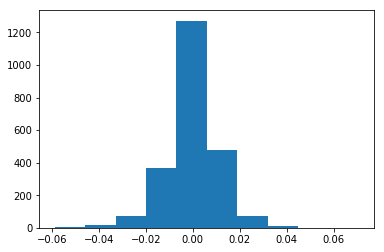

In [27]:
plt.hist(df_returns['AEX']);

#### Estimate VaR and ES, based on Variance-Covariance method, Student-t distribution with 3, 4, 5, 6 degrees of freedom

In [28]:
from scipy.stats import t

In [29]:
degree_of_freedom = [3,4,5,6]

In [30]:
# at 97.5% confidence level
for df in degree_of_freedom:
    
    tppf = t.ppf(alphas[0], df)
    
    var_975_1d_t= t.ppf(confidence_levels[0], df) * pf_std_euro - pf_mean_euro
    
    es_975_1d_t = -1/alphas[0] * (1-df)**(-1) * (df-2+tppf**2) * t.pdf(tppf, df)*pf_std_euro - pf_mean_euro
    
    
    print(f'Student-t distribution with {df} degree of freedom: \nVaR 97.5% 1d: {np.round(var_975_1d_t,3)}, ES 97.5% 1d: {np.round(es_975_1d_t,3)}\n')

Student-t distribution with 3 degree of freedom: 
VaR 97.5% 1d: 2454923.442, ES 97.5% 1d: 3300737.117

Student-t distribution with 4 degree of freedom: 
VaR 97.5% 1d: 2139695.19, ES 97.5% 1d: 2555047.384

Student-t distribution with 5 degree of freedom: 
VaR 97.5% 1d: 1979858.426, ES 97.5% 1d: 2247133.72

Student-t distribution with 6 degree of freedom: 
VaR 97.5% 1d: 1883838.33, ES 97.5% 1d: 2090347.913



In [31]:
# compare with VaR and ES under standard normal distribution
print(f'VaR 97.5% 1d: {np.round(var_975_1d,3)}, ES 97.5% 1d: {np.round(es_975_1d,3)}')

VaR 97.5% 1d: 1505761.31, ES 97.5% 1d: 1799123.661


In [32]:
# at 99% confidence level
for df in degree_of_freedom:
    
    tppf = t.ppf(alphas[1], df)
    
    var_990_1d_t= t.ppf(confidence_levels[1], df) * pf_std_euro - pf_mean_euro
    
    es_990_1d_t = -1/alphas[1] * (1-df)**(-1) * (df-2+tppf**2) * t.pdf(tppf, df) * pf_std_euro - pf_mean_euro
    
    
    print(f'Student-t distribution with {df} degree of freedom: \nVaR 97.5% 1d: {np.round(var_990_1d_t,3)}, ES 97.5% 1d: {np.round(es_990_1d_t,3)}\n')

Student-t distribution with 3 degree of freedom: 
VaR 97.5% 1d: 3509503.671, ES 97.5% 1d: 4960907.708

Student-t distribution with 4 degree of freedom: 
VaR 97.5% 1d: 2893214.485, ES 97.5% 1d: 3587992.354

Student-t distribution with 5 degree of freedom: 
VaR 97.5% 1d: 2596607.791, ES 97.5% 1d: 3017389.948

Student-t distribution with 6 degree of freedom: 
VaR 97.5% 1d: 2424039.005, ES 97.5% 1d: 2720529.681



In [33]:
# compare with VaR and ES under standard normal distribution
print(f'VaR 99% 1d: {np.round(var_990_1d,3)}, ES 99% 1d: {np.round(es_990_1d,3)}')

VaR 99% 1d: 1790229.811, ES 99% 1d: 2053333.087


#### Estimate VaR and ES, based on Historical Simulation method

In [34]:
# calculate the historical losses, and order them in increasing order
df_returns = df_returns[:] # select the simulation period
pf_losses = np.sort(principle * df_returns.dot(weights))

In [35]:
# at 97.5% confidence level
var_975_1d_hsm = pf_losses[int(alphas[0]*len(pf_losses))]
es_975_1d_hsm = pf_losses[0:int(alphas[0]*len(pf_losses))].mean()

In [36]:
print(f'VaR 97.5% 1d: {np.round(var_975_1d_hsm,3)}, ES 97.5% 1d: {np.round(es_975_1d_hsm,3)}')

VaR 97.5% 1d: -1605894.394, ES 97.5% 1d: -2332376.66


In [37]:
# at 99% confidence level
var_990_1d_hsm = pf_losses[int(alphas[1]*len(pf_losses))]
es_990_1d_hsm = pf_losses[0:int(alphas[1]*len(pf_losses))].mean()

In [38]:
print(f'VaR 99% 1d: {np.round(var_990_1d_hsm,3)}, ES 99% 1d: {np.round(es_990_1d_hsm,3)}')

VaR 99% 1d: -2314570.75, ES 99% 1d: -3059666.776


#### Estimate VaR and ES, based on Constant Conditional Correlation method

In [39]:
# Fill empty cells
df_returns = df_returns.ffill().iloc[1:,:]

# Rescale data for optimizing algorithm
df_returns = df_returns*1000

In [40]:
# divide train and test split
split_date = dt.datetime(2012,1,1)

Iteration:     10,   Func. Count:     66,   Neg. LLF: 1942.8902871714138
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1942.8902787751572
            Iterations: 11
            Function evaluations: 72
            Gradient evaluations: 11
Iteration:     10,   Func. Count:     67,   Neg. LLF: 2268.847773135488
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2268.8416963030263
            Iterations: 13
            Function evaluations: 86
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2001.2019927055394
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1970.1577436042735
            Iterations: 8
            Function evaluations: 55
            Gradient evaluations: 8
Iteration:     

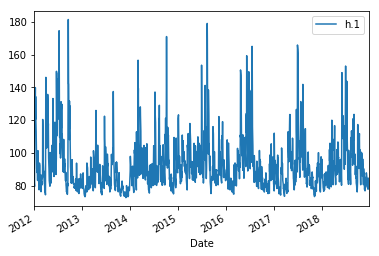

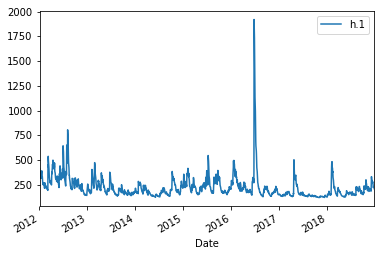

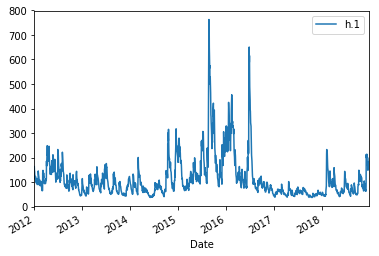

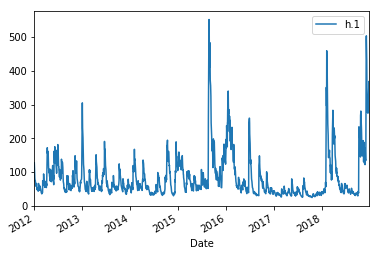

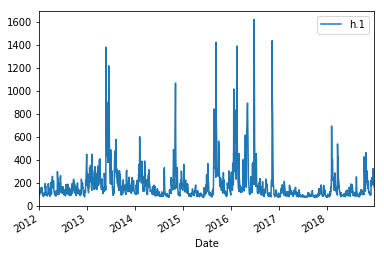

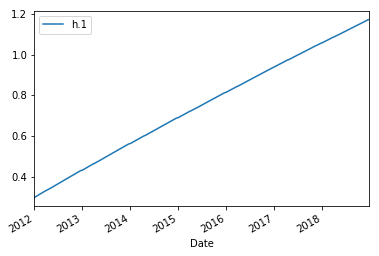

In [41]:
from arch import arch_model

# Create empty dict to store parameter values
params_dict = {}

# Create dataframe to store volatility forecasts
vola_forecast = pd.DataFrame(index=df_returns.loc[split_date:end].index)

# Fit GARCH(1,1) for each instrument
for instrument in df_returns.columns:

    garch11 = arch_model(df_returns[instrument], p=1, q=1, dist='Normal', vol='Garch')
    res = garch11.fit(update_freq=10, last_obs=split_date)
    
    forecasts = res.forecast(start=split_date)
    forecasts.variance[split_date:].plot()
    
    vola_forecast[instrument] = forecasts.variance[split_date:]
    params_dict[instrument] = res.params

In [42]:
vola_forecast

,DBA,EWQ,AEX,GSPC,N225,euribor3m
Date,,,,,,
2012-01-02,81.784777,411.719201,163.230670,127.813467,99.834168,0.297617
2012-01-03,80.509533,371.814492,146.369876,115.947199,99.723532,0.298152
2012-01-04,79.671388,371.830660,145.585705,102.200987,99.651091,0.298687
2012-01-05,132.769966,387.058559,138.335405,90.945206,107.115380,0.299222
2012-01-06,115.809590,384.356457,124.277743,82.442432,126.554820,0.299757
...,...,...,...,...,...,...
2018-12-19,78.761271,235.138505,148.662101,274.381762,185.689485,1.170503
2018-12-20,77.976133,220.845444,183.148508,275.382973,328.899060,1.170955
2018-12-21,84.746791,226.993674,162.803958,302.405162,269.306352,1.171408


#### Estimate VaR and ES, based on Filtered Historical Simulation method with EWMA for each risk factor ####